# Spectral Map

In [1]:
# import necessary Python packages
import os
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Reference object

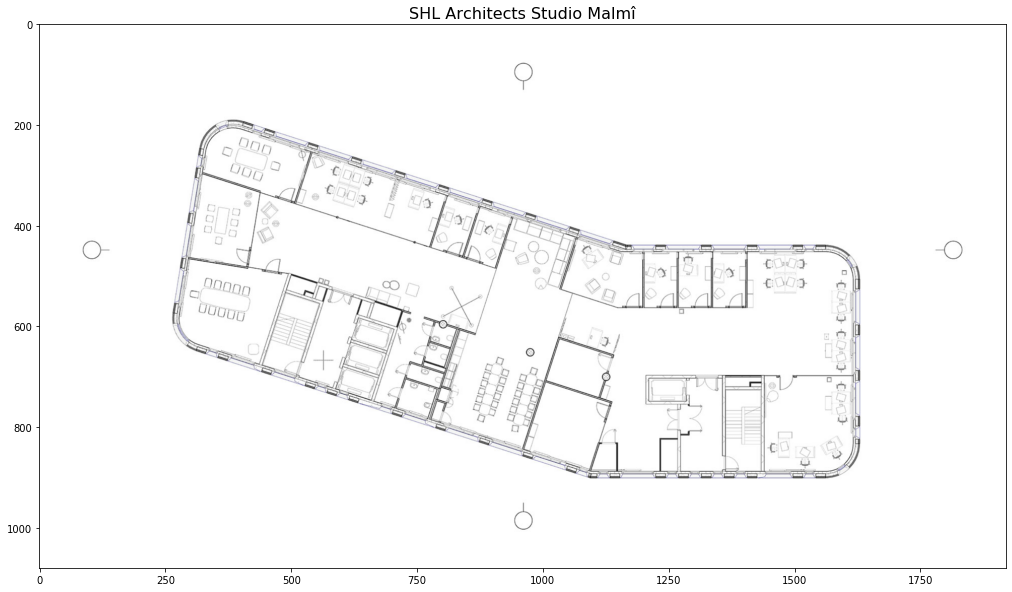

In [2]:
img=mpimg.imread('data/layout.jpg')
fig = plt.figure(figsize = (30,10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img, interpolation="bilinear")
a.set_title('SHL Architects Studio Malmî', fontsize=16);

## Get structured data

In [3]:
import pandas as pd
# Load data 
rooms = pd.read_csv('data/room_schedule.csv', skiprows=[2], keep_default_na=False)
rooms.columns = rooms.iloc[0]
rooms.drop([0], inplace=True)
rooms['Area'] = rooms['Area'].map(lambda x: x.rstrip(' m²'))
rooms

,Number,Name,Area,Perimeter
1,1,CTO Office,9.52,12794
2,2,Legal Eagle Office,9.51,12786
3,3,PA Office,9.51,12786
4,4,CEO Office,21.62,18879
5,5,HR Office,9.30,12587
6,6,CFO Office,9.25,12565
7,7,Sales Arena,39.79,28112
8,8,Swedese,26.82,21385
9,9,Offecct,25.06,20274
10,10,WC1,2.21,5951


In [4]:
import pandas as pd
# Load data 
doors = pd.read_csv('data/door_schedule.csv', skiprows=[2], keep_default_na=False)
doors.columns = doors.iloc[0]
doors.drop([0], inplace=True)
doors

,Mark,From Room: Number,To Room: Number,Rough Width,Rough Height
1,632296,1,16,1015,2102
2,642739,2,16,1015,2102
3,650548,3,16,1015,2102
4,196335,4,16,1015,2102
5,654502,6,16,1015,2102
6,320281,7,16,970,1680
7,320293,7,16,970,1680
8,655552,8,16,1015,2102
9,652881,9,16,1015,2102
10,542383,10,16,810,1900


In [5]:
doors['From Room: Number'][:-1] = doors['From Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])
doors['To Room: Number'][:-1] = doors['To Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])

In [6]:
doors = doors.rename(columns={'From Room: Number': 'From Room', 'To Room: Number': 'To Room', 'Rough Width': 'Width', 'Rough Height': 'Height'})
doors

,Mark,From Room,To Room,Width,Height
1,632296,CTO Office,Open,1015,2102
2,642739,Legal Eagle Office,Open,1015,2102
3,650548,PA Office,Open,1015,2102
4,196335,CEO Office,Open,1015,2102
5,654502,CFO Office,Open,1015,2102
6,320281,Sales Arena,Open,970,1680
7,320293,Sales Arena,Open,970,1680
8,655552,Swedese,Open,1015,2102
9,652881,Offecct,Open,1015,2102
10,542383,WC1,Open,810,1900


## Preprocessing

In [7]:
import seaborn as sns

In [8]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

In [9]:
def calculateCovariance(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

In [10]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [11]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

In [12]:
def whiten(X):
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

### Preprocessing rooms

In [13]:
ra = np.array(rooms['Area']).astype(float)
rp = np.array(rooms['Perimeter']).astype(int)
#labels = np.array(rooms['Name'])

In [14]:
R = np.array([ra, rp]).T
R.shape

(25, 2)

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


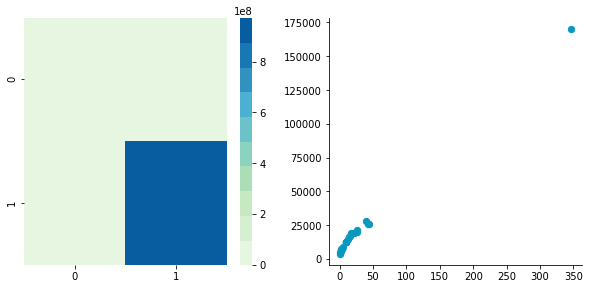

In [15]:
plotDataAndCov(R)
plt.show()
plt.close()

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


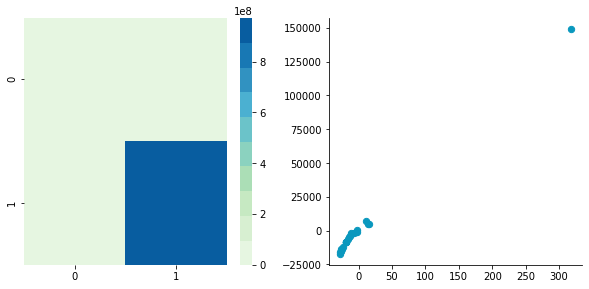

In [16]:
R = center(R)
plotDataAndCov(R)
plt.show()
plt.close()

Covariance matrix:
 [[1.         0.99810803]
 [0.99810803 1.        ]]


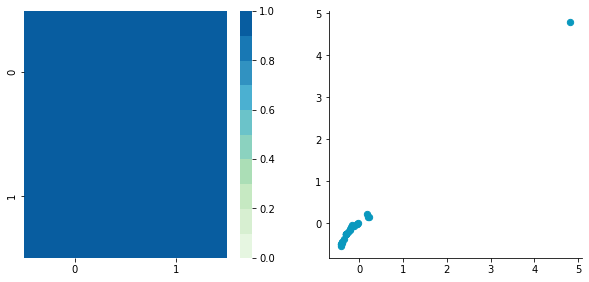

In [17]:
R = standardize(R)
plotDataAndCov(R)
plt.show()
plt.close()

In [18]:
dw = np.array(doors['Width'][:-1]).astype(int)
dh = np.array(doors['Height'][:-1]).astype(int)

Covariance matrix:
 [[ 9.94742282e-01 -3.24338527e-15]
 [-3.24338527e-15  9.99994995e-01]]


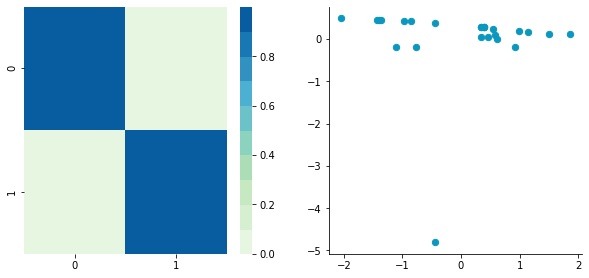

In [19]:
R = whiten(R)
plotDataAndCov(R)
plt.show()
plt.close()

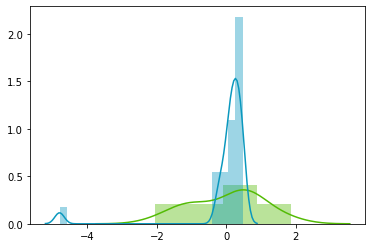

In [20]:
sns.distplot(R[:,0], color="#53BB04")
sns.distplot(R[:,1], color="#0A98BE")
plt.show()
plt.close()

### Preprocessing doors

In [21]:
D = np.array([dw, dh]).T
D.shape

(26, 2)

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


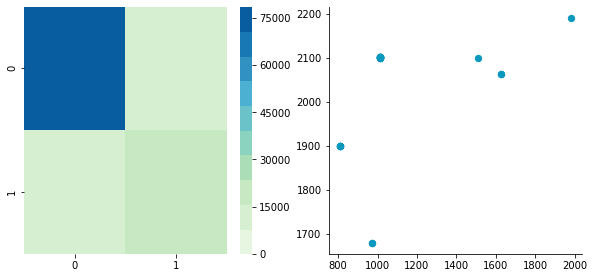

In [22]:
plotDataAndCov(D)
plt.show()
plt.close()

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


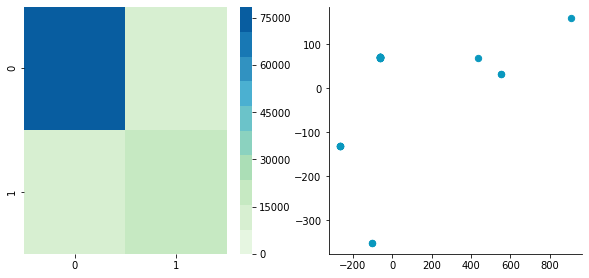

In [23]:
D = center(D)
plotDataAndCov(D)
plt.show()
plt.close()

Covariance matrix:
 [[1.         0.41265099]
 [0.41265099 1.        ]]


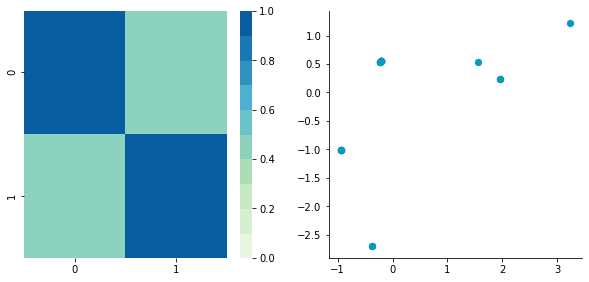

In [24]:
D = standardize((D))
plotDataAndCov(D)
plt.show()
plt.close()

Covariance matrix:
 [[9.99992921e-01 6.98715852e-17]
 [6.98715852e-17 9.99982975e-01]]


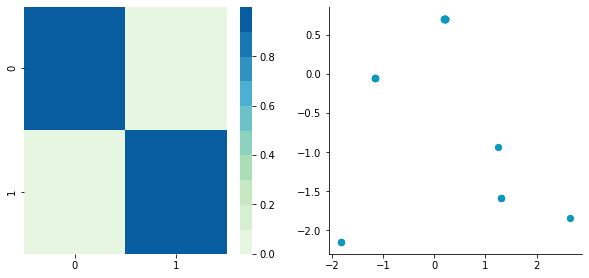

In [25]:
D = whiten(D)
plotDataAndCov(D)
plt.show()
plt.close()

In [26]:
D

array([[ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [-1.82748406, -2.14685435],
       [-1.82748406, -2.14685435],
       [ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [-1.15959986, -0.057223  ],
       [-1.15959986, -0.057223  ],
       [ 0.20093399,  0.70250352],
       [ 0.20093399,  0.70250352],
       [-1.15959986, -0.057223  ],
       [-1.15959986, -0.057223  ],
       [ 0.1811558 ,  0.7047635 ],
       [ 0.20093399,  0.70250352],
       [-1.15959986, -0.057223  ],
       [ 0.20093399,  0.70250352],
       [ 0.1811558 ,  0.7047635 ],
       [ 1.31096343, -1.58723215],
       [ 0.1811558 ,  0.7047635 ],
       [ 1.31096343, -1.58723215],
       [ 0.1811558 ,  0.7047635 ],
       [ 2.65321527, -1.8504285 ],
       [ 1.2429282 , -0.94187623]])

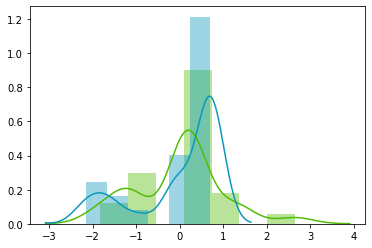

In [27]:
sns.distplot(D[:,0], color="#53BB04")
sns.distplot(D[:,1], color="#0A98BE")
plt.show()
plt.close()

## Graph construction

In [28]:
fr = np.array(doors['From Room'][:-1])
to = np.array(doors['To Room'][:-1])

In [29]:
pairs = np.vstack((fr, to)).T
pairs

array([['CTO Office', 'Open'],
       ['Legal Eagle Office', 'Open'],
       ['PA Office', 'Open'],
       ['CEO Office', 'Open'],
       ['CFO Office', 'Open'],
       ['Sales Arena', 'Open'],
       ['Sales Arena', 'Open'],
       ['Swedese', 'Open'],
       ['Offecct', 'Open'],
       ['WC1', 'Open'],
       ['WC3', 'Open'],
       ['VR Room', 'Open'],
       ['Open', 'HR Office'],
       ['Open', 'WC2'],
       ['Open', 'WC4'],
       ['Open', 'Copy'],
       ['Open', 'EFG'],
       ['Open', 'Storage'],
       ['Marketing', 'Open'],
       ['Recovery', 'Open'],
       ['Entrance1', 'Open'],
       ['Entrance1', 'Stairs1'],
       ['Entrance2', 'Open'],
       ['Entrance2', 'Stairs2'],
       ['Entrance2', 'Revision'],
       ['Revision', 'Open']], dtype=object)

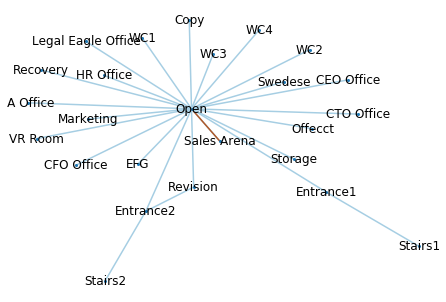

In [30]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
 
# Create a networkx graph object
G = nx.MultiGraph() 
 
# Add edges to to the graph object
# Each tuple represents an edge between two nodes
G.add_edges_from(pairs[:, [0, 1]])
c = np.array(G.edges).T[2].astype(int)
my_pos = nx.spring_layout(G, seed = 56)
# Draw the resulting graph
nx.draw(G, pos=my_pos, with_labels=True, edge_color=c, width=1.5, node_size=4, edge_cmap=plt.cm.Paired)

In [31]:
pairs = np.vstack((fr, to, c)).T
pairs

array([['CTO Office', 'Open', 0],
       ['Legal Eagle Office', 'Open', 0],
       ['PA Office', 'Open', 0],
       ['CEO Office', 'Open', 0],
       ['CFO Office', 'Open', 0],
       ['Sales Arena', 'Open', 0],
       ['Sales Arena', 'Open', 1],
       ['Swedese', 'Open', 0],
       ['Offecct', 'Open', 0],
       ['WC1', 'Open', 0],
       ['WC3', 'Open', 0],
       ['VR Room', 'Open', 0],
       ['Open', 'HR Office', 0],
       ['Open', 'WC2', 0],
       ['Open', 'WC4', 0],
       ['Open', 'Copy', 0],
       ['Open', 'EFG', 0],
       ['Open', 'Storage', 0],
       ['Marketing', 'Open', 0],
       ['Recovery', 'Open', 0],
       ['Entrance1', 'Open', 0],
       ['Entrance1', 'Stairs1', 0],
       ['Entrance2', 'Open', 0],
       ['Entrance2', 'Stairs2', 0],
       ['Entrance2', 'Revision', 0],
       ['Revision', 'Open', 0]], dtype=object)

In [32]:
G.nodes(data=True)

NodeDataView({'CTO Office': {}, 'Open': {}, 'Legal Eagle Office': {}, 'PA Office': {}, 'CEO Office': {}, 'CFO Office': {}, 'Sales Arena': {}, 'Swedese': {}, 'Offecct': {}, 'WC1': {}, 'WC3': {}, 'VR Room': {}, 'HR Office': {}, 'WC2': {}, 'WC4': {}, 'Copy': {}, 'EFG': {}, 'Storage': {}, 'Marketing': {}, 'Recovery': {}, 'Entrance1': {}, 'Stairs1': {}, 'Entrance2': {}, 'Stairs2': {}, 'Revision': {}})

In [33]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {}), ('Open', 'Legal Eagle Office', 0, {}), ('Open', 'PA Office', 0, {}), ('Open', 'CEO Office', 0, {}), ('Open', 'CFO Office', 0, {}), ('Open', 'Sales Arena', 0, {}), ('Open', 'Sales Arena', 1, {}), ('Open', 'Swedese', 0, {}), ('Open', 'Offecct', 0, {}), ('Open', 'WC1', 0, {}), ('Open', 'WC3', 0, {}), ('Open', 'VR Room', 0, {}), ('Open', 'HR Office', 0, {}), ('Open', 'WC2', 0, {}), ('Open', 'WC4', 0, {}), ('Open', 'Copy', 0, {}), ('Open', 'EFG', 0, {}), ('Open', 'Storage', 0, {}), ('Open', 'Marketing', 0, {}), ('Open', 'Recovery', 0, {}), ('Open', 'Entrance1', 0, {}), ('Open', 'Entrance2', 0, {}), ('Open', 'Revision', 0, {}), ('Entrance1', 'Stairs1', 0, {}), ('Entrance2', 'Stairs2', 0, {}), ('Entrance2', 'Revision', 0, {})])

## Embed Attributes

In [34]:
room_vector = []
area = 0.0
perimeter = 0
nx.set_node_attributes(G, room_vector, 'vector')
nx.set_node_attributes(G, area, 'area')
nx.set_node_attributes(G, perimeter, 'perimeter')

In [35]:
G.nodes.data()

NodeDataView({'CTO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Open': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Legal Eagle Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'PA Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'CEO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'CFO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Sales Arena': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Swedese': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Offecct': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC1': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC3': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'VR Room': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'HR Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC2': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC4': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Copy': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'EFG': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Storage': {'vector': [], 'area'

In [36]:
for i, node in enumerate(rooms['Name']):
    G.nodes[node]['vector'] = R[i]
    G.nodes[node]['area'] = ra[i]
    G.nodes[node]['perimeter'] = rp[i]

In [37]:
G.nodes.data()

NodeDataView({'CTO Office': {'vector': array([0.39616225, 0.27454983]), 'area': 9.52, 'perimeter': 12794}, 'Open': {'vector': array([-0.44475996, -4.80067892]), 'area': 345.81, 'perimeter': 170216}, 'Legal Eagle Office': {'vector': array([0.39446208, 0.27475397]), 'area': 9.51, 'perimeter': 12786}, 'PA Office': {'vector': array([0.39446208, 0.27475397]), 'area': 9.51, 'perimeter': 12786}, 'CEO Office': {'vector': array([0.58465247, 0.08518988]), 'area': 21.62, 'perimeter': 18879}, 'CFO Office': {'vector': array([0.34350021, 0.28027021]), 'area': 9.25, 'perimeter': 12565}, 'Sales Arena': {'vector': array([ 0.91731101, -0.20069369]), 'area': 39.79, 'perimeter': 28112}, 'Swedese': {'vector': array([0.60897589, 0.00556079]), 'area': 26.82, 'perimeter': 21385}, 'Offecct': {'vector': array([0.4641296 , 0.03672705]), 'area': 25.06, 'perimeter': 20274}, 'WC1': {'vector': array([-1.36387001,  0.43973645]), 'area': 2.21, 'perimeter': 5951}, 'WC3': {'vector': array([-0.85119974,  0.41648648]), 'a

In [38]:
door_vector = []
width = 0
height = 0
nx.set_edge_attributes(G, door_vector, 'vector')
nx.set_edge_attributes(G, width, 'width')
nx.set_edge_attributes(G, height, 'height')

In [39]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Legal Eagle Office', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'PA Office', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'CEO Office', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'CFO Office', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Sales Arena', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Sales Arena', 1, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Swedese', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Offecct', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC1', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC3', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'VR Room', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'HR Office', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC2', 0, {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC4', 0, {'vector': [], 'width': 0, 'heig

In [40]:
for i, pair in enumerate(pairs):
    G.edges[(pair[0], pair[1], pair[2])]['vector'] = D[i]
    G.edges[(pair[0], pair[1], pair[2])]['width'] = dw[i]
    G.edges[(pair[0], pair[1], pair[2])]['height'] = dh[i]

In [41]:
G.edges(data=True,keys=True)

MultiEdgeDataView([('CTO Office', 'Open', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'Legal Eagle Office', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'PA Office', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'CEO Office', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'CFO Office', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'Sales Arena', 0, {'vector': array([-1.82748406, -2.14685435]), 'width': 970, 'height': 1680}), ('Open', 'Sales Arena', 1, {'vector': array([-1.82748406, -2.14685435]), 'width': 970, 'height': 1680}), ('Open', 'Swedese', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'Offecct', 0, {'vector': array([0.20093399, 0.70250352]), 'width': 1015, 'height': 2102}), ('Open', 'WC1', 0, {'vector': array([-1.15959986,

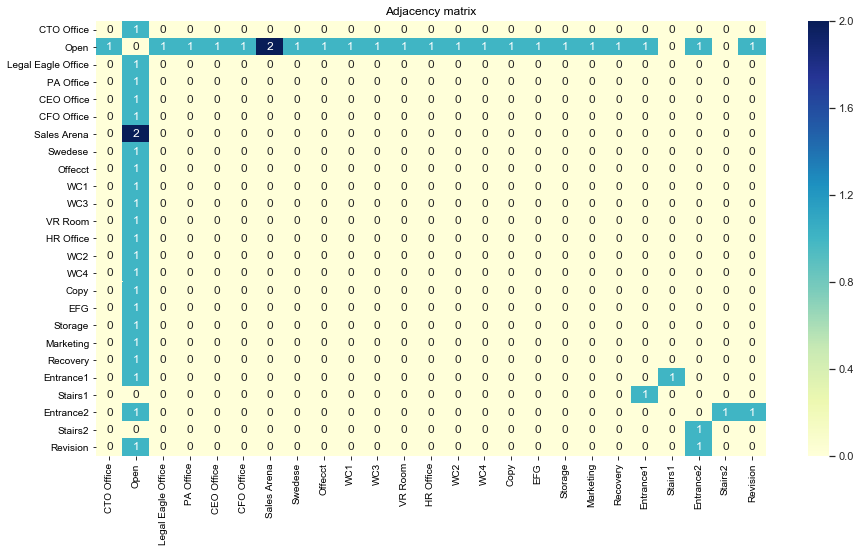

In [42]:
A = nx.to_numpy_matrix(G)
plt.figure(figsize=(15,8))
plt.title('Adjacency matrix')
sns.set()
sns.heatmap(A, cmap="YlGnBu", annot=True, xticklabels=G.nodes, yticklabels=G.nodes);

In [43]:
node_degrees = [x[1] for x in list(G.degree())]

In [44]:
D = np.diag(node_degrees)

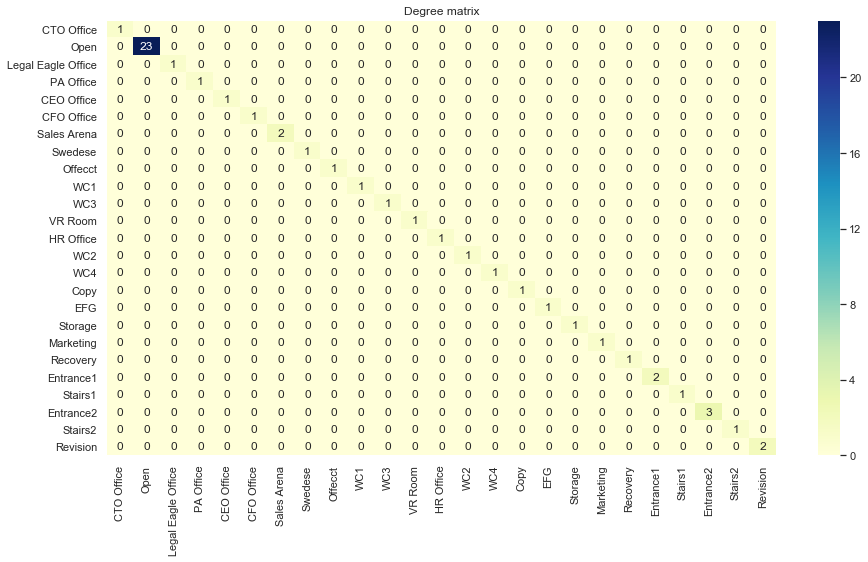

In [45]:
plt.figure(figsize=(15,8))
plt.title('Degree matrix')
sns.set()
sns.heatmap(D, cmap="YlGnBu", annot=True, xticklabels=G.nodes, yticklabels=G.nodes);

In [46]:
L = D - A

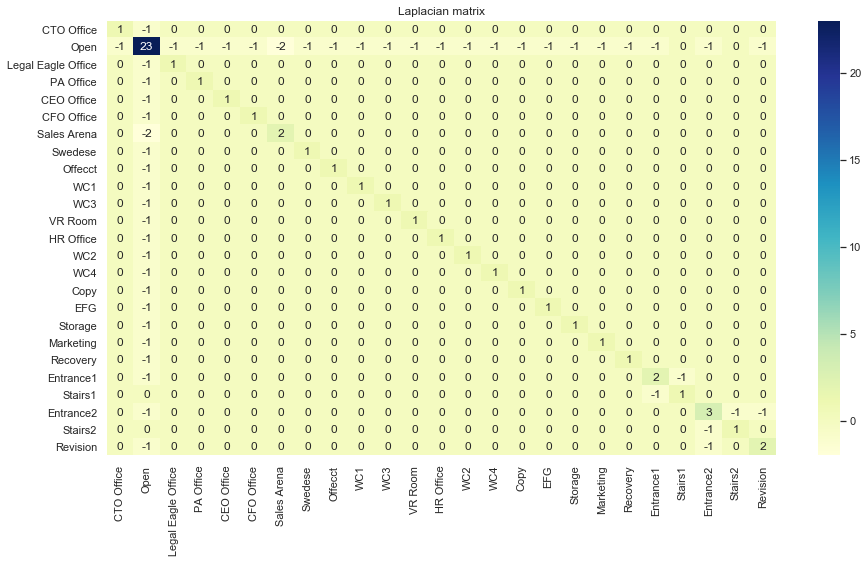

In [47]:
plt.figure(figsize=(15,8))
plt.title('Laplacian matrix')
sns.set()
sns.heatmap(L, cmap="YlGnBu", annot=True, xticklabels=G.nodes, yticklabels=G.nodes);

Largest eigenvalue: 24.094452148072975
Smallest eigenvalue: -3.4614192028996347e-16


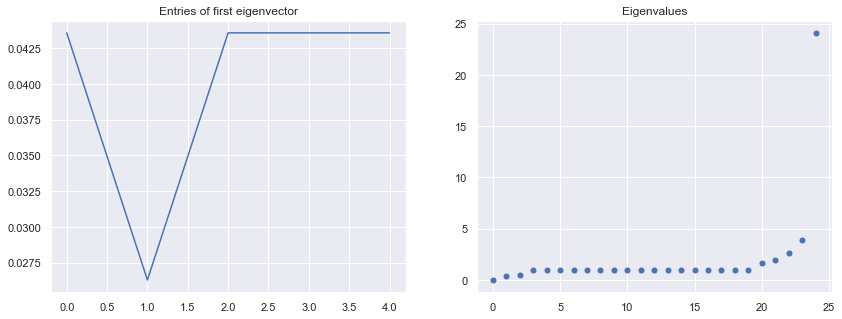

In [48]:
import pandas as pd
from networkx import *
eigvals, eigvecs=np.linalg.eigh(L)
print("Largest eigenvalue:", max(eigvals))
print("Smallest eigenvalue:", min(eigvals))

eigvecs = pd.DataFrame(eigvecs)

fig = plt.figure(figsize=(14,5))
fig.add_subplot(121)
plt.title("Entries of first eigenvector")
plt.plot(eigvecs.iloc[:5,1])
    
fig.add_subplot(122)
plt.plot(eigvals, '.', markerSize = 10)
plt.title("Eigenvalues");

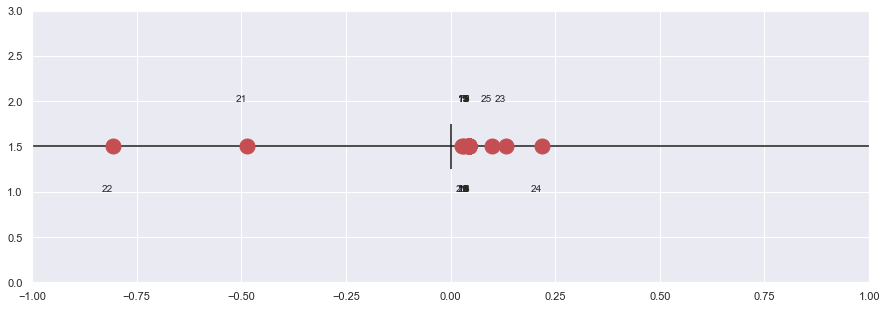

In [49]:
# set up figure
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xlim(-1,1)
ax.set_ylim(0,3)

# draw lines
xmin = -5
xmax = 5
y = 1.5
height = 0.5

plt.hlines(y, xmin, xmax)
plt.vlines(0, y - height / 2., y + height / 2.)

# use eigenvectors to map points to the line
for index, px in enumerate(eigvecs.iloc[:,1]):
    plt.plot(px, y, 'ro', ms = 15, mfc = 'r')
    plt.text(px, y + 0.5*(-1)**index, str(index+1), horizontalalignment='right', size=10)

plt.show();

In [50]:
X = np.array([list(G.node[key]['vector']) for key in list(my_pos.keys())])

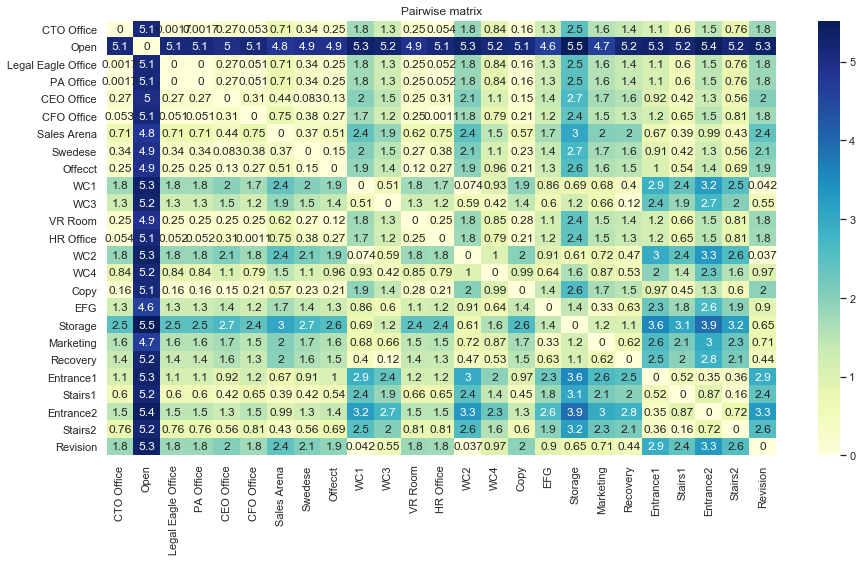

In [51]:
from sklearn.metrics import pairwise_distances
P = pairwise_distances(X)
plt.figure(figsize=(15,8))
plt.title('Pairwise matrix')
sns.set()
sns.heatmap(P, cmap="YlGnBu", annot=True, xticklabels=G.nodes, yticklabels=G.nodes);

In [52]:
labels = list(G.nodes)

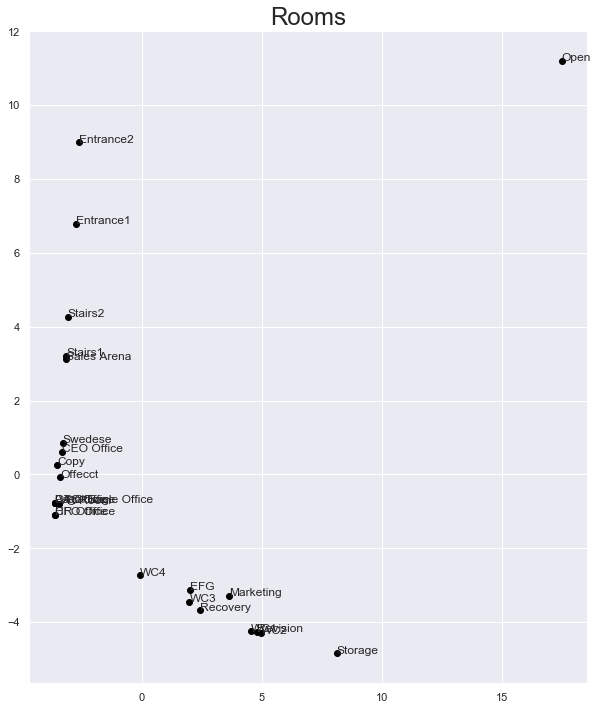

In [53]:
from sklearn.manifold import Isomap

# apply isomap with k = 6 and output dimension = 2
model = Isomap(n_components=2, n_neighbors=6)
proj = model.fit_transform(P)
# plot results
plt.figure(figsize=(10,12))
plt.scatter(proj[:, 0], proj[:, 1], c='black')
plt.title('Rooms', size=24)
for i in range(len(labels)):
    plt.text(proj[i][0], proj[i][1], s=labels[i], size=12)

In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# for Notebook
%matplotlib inline

In [55]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()))
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

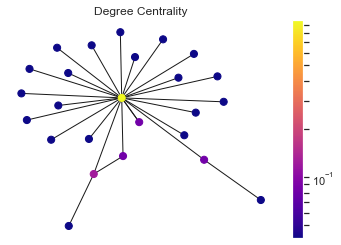

In [56]:
draw(G, my_pos, nx.degree_centrality(G), 'Degree Centrality')

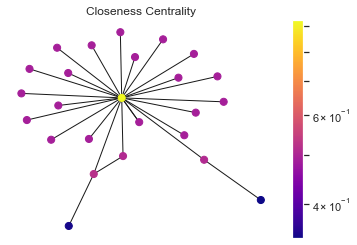

In [57]:
draw(G, my_pos, nx.closeness_centrality(G), 'Closeness Centrality')

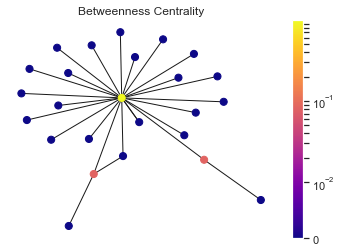

In [58]:
draw(G, my_pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

In [191]:
G2 = nx.Graph(G)

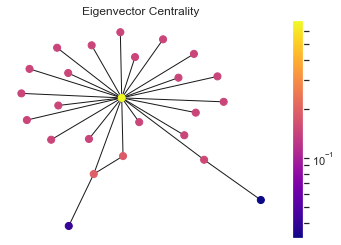

In [193]:
draw(G2, my_pos, nx.eigenvector_centrality(G2), 'Eigenvector Centrality')

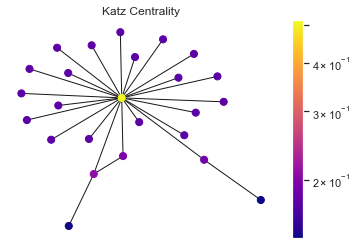

In [194]:
draw(G2, my_pos, nx.katz_centrality(G2), 'Katz Centrality')

In [275]:
from pygsp import graphs, filters
G8 = graphs.Logo()
G8.estimate_lmax()
g = filters.Heat(G8, tau=150)

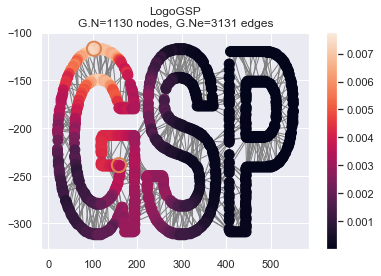

In [276]:
import numpy as np
DELTAS = [0, 700]
s = np.zeros(G8.N)
s[DELTAS] = 1
s = g.filter(s)
G8.plot_signal(s, highlight=DELTAS, backend='matplotlib')

In [277]:
G9 = graphs.Graph(A)

In [278]:
G9.estimate_lmax()
g = filters.Heat(G9, tau=100)
G9.set_coordinates(list(my_pos.values()))

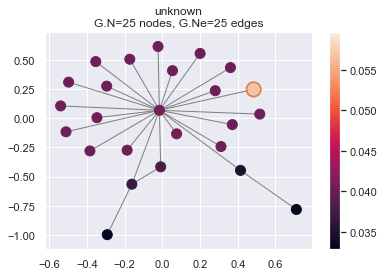

In [279]:
import numpy as np
DELTAS = [4]
s = np.zeros(G9.N)
s[DELTAS] = 1
s = g.filter(s)
G9.plot_signal(s, highlight=DELTAS, backend='matplotlib')

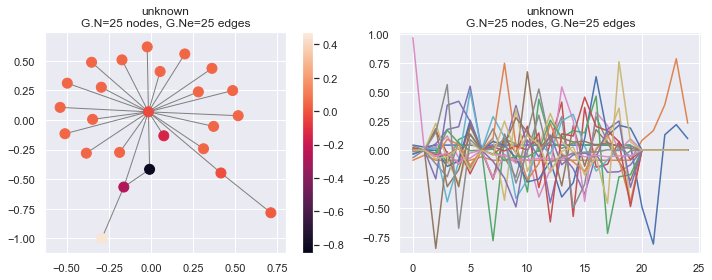

In [280]:
G9.compute_fourier_basis()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G9.plot_signal(G9.U[:, 20], ax=axes[0])
G9.set_coordinates('line1D')
G9.plot_signal(G9.U[:, 1:20], ax=axes[1])
fig.tight_layout()

Text(0.5, 1.0, 'Filter frequency response')

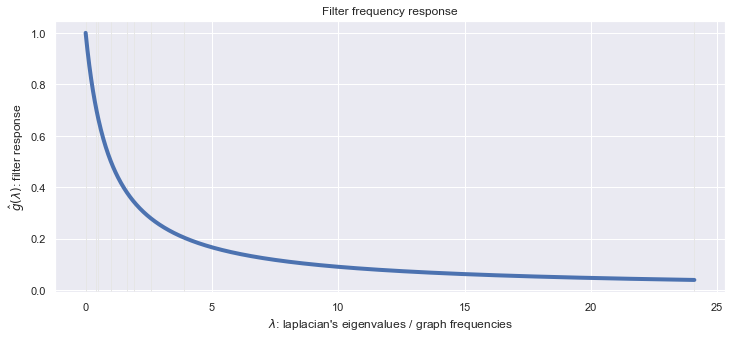

In [281]:
tau = 1
def g(x):
    return 1. / (1. + tau * x)
g = filters.Filter(G9, g)

fig, ax = plt.subplots(figsize=(12,5))
g.plot(plot_eigenvalues=True, ax=ax)
ax.set_title('Filter frequency response')